In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization

import plotly.offline as py
import plotly.graph_objs as go

import keras_tuner as kt

import tensorflow as tf

from IPython.display import SVG
import os

import datetime, time

from tensorflow import keras

import tensorflow as tf

import random

from keras import backend as K

from keras.regularizers import L1L2

## Objective
The aim of this kernal is to train an LSTM model to predict the future price of Gold based on past time series data. This kernal will use LSTM model from the Keras Library

## What is LSTM?

LSTM stands for long short-term memory networks, used in the field of Deep Learning. It is a variety of recurrent neural networks (RNNs) that are capable of learning long-term dependencies, especially in sequence prediction problems. LSTM has feedback connections, i.e., it is capable of processing the entire sequence of data, apart from single data points such as images. This finds application in speech recognition, machine translation, etc. LSTM is a special kind of RNN, which shows outstanding performance on a large variety of problems.

<center><img src = "https://miro.medium.com/max/1400/1*goJVQs-p9kgLODFNyhl9zA.gif" alt="LSTM aniamtion" width=700px></center>


In [2]:
tf.device('/device:GPU:0')

In [3]:
df = pd.read_csv(r"C:\Users\fnafisa\WORKSPACE\kaggle\data\gold\gold_price_data.csv")
df.head()

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


In [4]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df

,Date,Value
0,1970-01-01,35.20
1,1970-04-01,35.10
2,1970-07-01,35.40
3,1970-10-01,36.20
4,1971-01-01,37.40
...,...,...
10782,2020-03-09,1672.50
10783,2020-03-10,1655.70
10784,2020-03-11,1653.75
10785,2020-03-12,1570.70


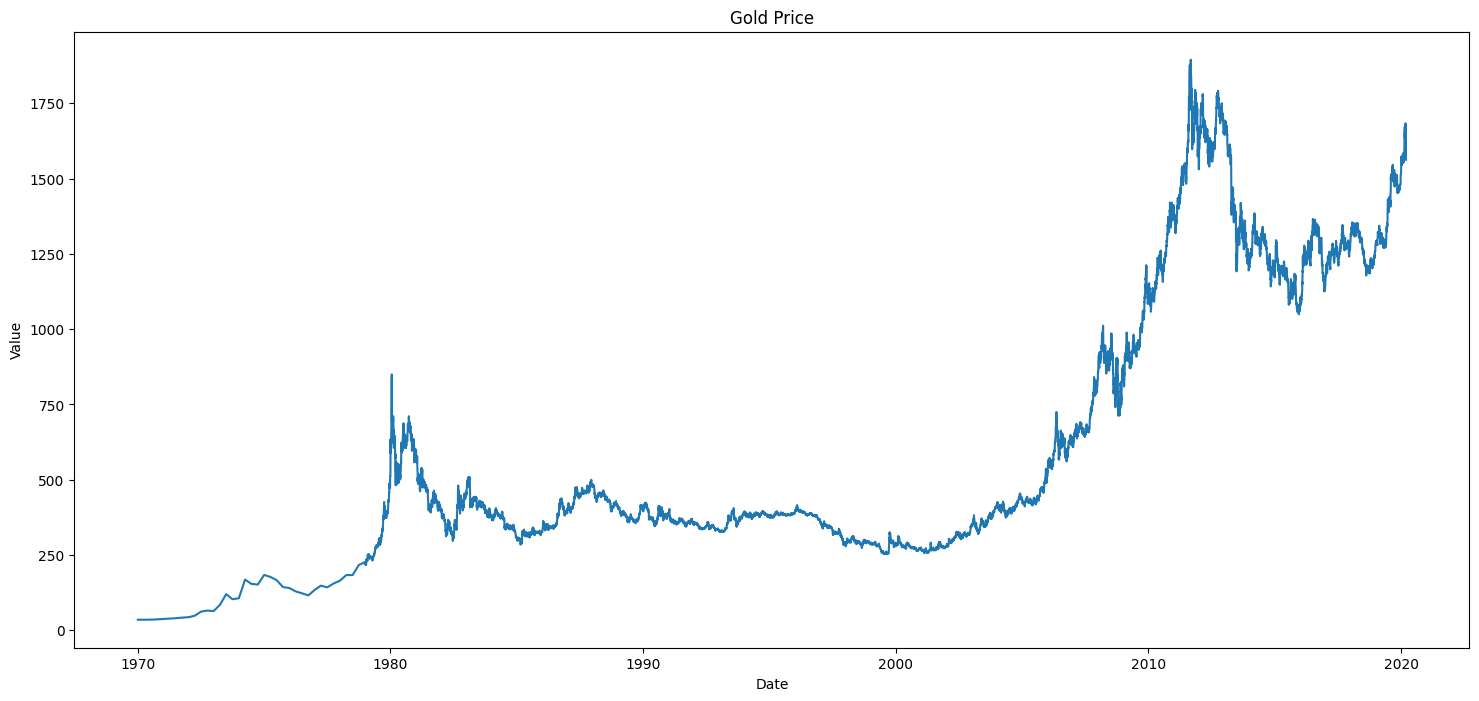

In [5]:
plt.figure(figsize = (18,8))
sns.lineplot(data=df, x="Date", y="Value")
plt.title('Gold Price')
plt.show()

### Data Split and Scaling

We will take the last 500 days data as testing data and the remaining will be used to train the model.

In [6]:
prediction_days = 500
df_train= df['Value'][:len(df['Value'])-prediction_days].values.reshape(-1,1)
df_test= df['Value'][len(df['Value'])-prediction_days:].values.reshape(-1,1)

scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

The use of prior time steps to predict the next time step is called the sliding window method. For short, it may be called the window method in some literature. In statistics and time series analysis, this is called a lag or lag method.

The number of previous time steps is called the window width or size of the lag.

Here we have used a window of 30 days.

In [7]:
def create_dataset(dataset, look_back=30):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(scaled_train)
testX, testY = create_dataset(scaled_test)

In [8]:
trainX.shape

(10257, 30)

In [9]:
testX.shape

(470, 30)

In [10]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Model Training

In [11]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
def model_builder(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32), return_sequences=True, input_shape= ( trainX.shape[1], trainX.shape[2]), bias_regularizer = L1L2(0.009, 0.004)))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.05)))
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
   
    model.compile(loss=root_mean_squared_error, optimizer='adam',metrics = ['mse'])
    
    return model

tuner = kt.RandomSearch(model_builder, objective='val_loss', max_trials = 10, executions_per_trial =1,directory = "./gold1/")

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', # Monitor the validation loss
                                                     min_delta=0,    # until it doesn't change (or gets worse)
                                                     patience=5,  # patience > 1 so it continutes if it is not consistently improving
                                                     verbose=0, 
                                                     mode='auto')]

tuner.search(x=trainX, y=trainY, epochs = 200, batch_size =512, validation_data=(testX, testY), callbacks=[callbacks],shuffle = True)


INFO:tensorflow:Reloading Oracle from existing project ./gold1/untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from ./gold1/untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [12]:
tuner.results_summary()

Results summary
Results in ./gold1/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
input_unit: 64
n_layers: 1
lstm_0_units: 384
Dropout_rate: 0.25
dense_activation: relu
lstm_1_units: 160
lstm_2_units: 352
lstm_3_units: 288
Score: 0.26164454221725464
Trial summary
Hyperparameters:
input_unit: 224
n_layers: 1
lstm_0_units: 96
Dropout_rate: 0.1
dense_activation: sigmoid
lstm_1_units: 320
lstm_2_units: 128
lstm_3_units: 256
Score: 0.26249805092811584
Trial summary
Hyperparameters:
input_unit: 384
n_layers: 3
lstm_0_units: 480
Dropout_rate: 0.5
dense_activation: sigmoid
lstm_1_units: 96
lstm_2_units: 128
lstm_3_units: 448
Score: 0.26285022497177124
Trial summary
Hyperparameters:
input_unit: 224
n_layers: 2
lstm_0_units: 320
Dropout_rate: 0.35000000000000003
dense_activation: sigmoid
lstm_1_units: 32
lstm_2_units: 96
lstm_3_units: 512
Score: 0.26317712664604187
Trial summary
Hyperparameters:
input_unit: 224
n_layers: 4
lstm_0_units: 224
Dropout_rate: 0.25
dense_activa

In [13]:
best_model = tuner.get_best_models(num_models=1)[0]

In [14]:
history = best_model.fit(x=trainX, y=trainY, epochs = 150, batch_size =128, validation_data=(testX, testY), shuffle=False, verbose=0)

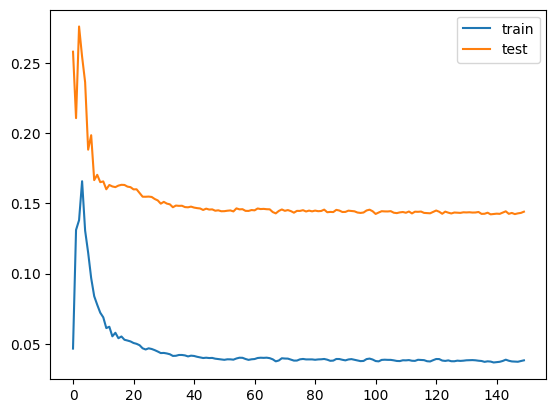

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [16]:
predicted_gold_price = best_model.predict(testX)

15/15 [==============================] - 1s 3ms/step


In [17]:
predicted_gold_price = scaler_test.inverse_transform(predicted_gold_price.reshape(-1, 1))

In [18]:
true = scaler_test.inverse_transform(testY.reshape(-1, 1))

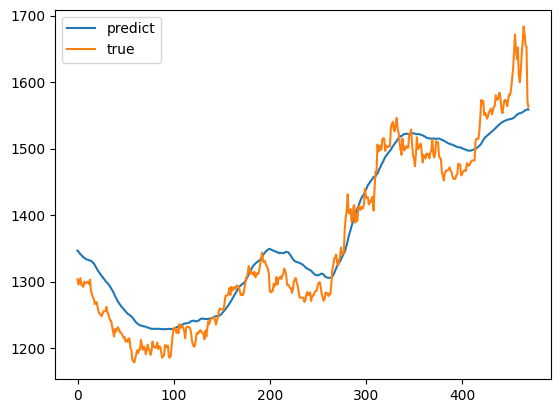

In [19]:
plt.plot(predicted_gold_price, label='predict')
plt.plot(true, label='true')
plt.legend()
plt.show()